<a href="https://colab.research.google.com/github/Aushinraj/Capstone-Project-The-Battle-Of-Neighbhorhoods/blob/main/4clus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary Libraries**

In [25]:
#importing the required libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from sklearn.neighbors import KNeighborsClassifier  #importing KNN library
from pandas import json_normalize  # tranforming json file into a pandas dataframe library
import matplotlib.pyplot as plt

**Define Foursquare Credentials and Version**

In [26]:
## Define Foursquare Credentials and Version
CLIENT_ID = 'ES3ZXR1ALGY0Q0YQVMG0RUMAO00WTUNG4K1C2JN5C2J0O1AZ' # Foursquare ID
CLIENT_SECRET = 'H3VNVPRCUTEX4NP23B4ANBLXWZKKIZ0VM4NKN0IQRYPYXPTW' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

**Getting the Location of Address**

In [27]:
address = 'NEW YORK CITY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7127281 -74.0060152


In [28]:
search_query = 'Hotel'
radius = 500
limit_hotels = 50

In [29]:
#url to be used for calling the API
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, limit_hotels)
url

'https://api.foursquare.com/v2/venues/search?client_id=ES3ZXR1ALGY0Q0YQVMG0RUMAO00WTUNG4K1C2JN5C2J0O1AZ&client_secret=H3VNVPRCUTEX4NP23B4ANBLXWZKKIZ0VM4NKN0IQRYPYXPTW&ll=40.7127281,-74.0060152&v=20180605&query=Hotel&radius=500&limit=50'

**Send Get Request for result**

In [30]:
#making the call and holding  the resulting json file in results

results = requests.get(url).json()

**Get relevant part of JSON and transform it into a pandas dataframe**

In [31]:
# assign relevant part of JSON to venues
hotels = results['response']['venues']

# tranform venues into a dataframe
hotels_df = json_normalize(hotels)
hotels_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood
0,56d8c0f8498edb854f926e6a,"The Beekman, A Thompson Hotel","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622757655,False,123 Nassau St,Beekman St,40.711173,-74.006702,"[{'label': 'display', 'lat': 40.7111725, 'lng'...",182,10038,US,New York,NY,United States,"[123 Nassau St (Beekman St), New York, NY 1003...",NaN,NaN
1,57c640ad498e74977f98372f,Four Seasons Hotel New York Downtown,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622757655,False,27 Barclay St,Broadway,40.712612,-74.009380,"[{'label': 'display', 'lat': 40.71261246501983...",284,10007,US,New York,NY,United States,"[27 Barclay St (Broadway), New York, NY 10007,...",NaN,NaN
2,4a6e3e75f964a5204ed41fe3,"Gild Hall, A Thompson Hotel","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622757655,False,15 Gold St,at Platt St,40.707887,-74.007103,"[{'label': 'display', 'lat': 40.7078871, 'lng'...",546,10038,US,New York,NY,United States,"[15 Gold St (at Platt St), New York, NY 10038,...",NaN,NaN
3,5a91fa58e679bc57ca94db72,Artezen Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622757655,False,24 John St,NaN,40.709585,-74.008780,"[{'label': 'display', 'lat': 40.709585, 'lng':...",420,10038,US,New York,NY,United States,"[24 John St, New York, NY 10038, United States]",563082986,NaN
4,4ae77379f964a5206cab21e3,Duane Street Hotel,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1622757655,False,130 Duane St,Church St,40.715858,-74.007446,"[{'label': 'display', 'lat': 40.7158584594727,...",368,10013,US,New York,NY,United States,"[130 Duane St (Church St), New York, NY 10013,...",40822074,NaN


**Cleaning The Dataframe**

In [ ]:
# keep only columns that include venue name,categories,lat,lng
filtered_columns = ['name', 'categories','location.lat','location.lng']
hotels_df_filtered = hotels_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered['categories'] = hotels_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered.columns = [column.split('.')[-1] for column in hotels_df_filtered.columns]

hotels_df_filtered

,name,categories,lat,lng
0,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
1,Four Seasons Hotel New York Downtown,Hotel,40.712612,-74.009380
2,"Gild Hall, A Thompson Hotel",Hotel,40.707887,-74.007103
3,Artezen Hotel,Hotel,40.709585,-74.008780
4,Duane Street Hotel,Hotel,40.715858,-74.007446
5,Smyth Hotel,Hotel,40.715144,-74.009183
6,Cosmopolitan Hotel - TriBeCa,Hotel,40.715622,-74.009115
7,Spa @ Four Seasons Hotel New York Downtown,Spa,40.712801,-74.009245
8,The Angel Hotel,None,40.712441,-74.007118
9,Sheraton Frankfurt hotel,None,40.712305,-74.007118


In [ ]:
#keeping only venues with the category "Hotel"

hotels_df_filtered = hotels_df_filtered[hotels_df_filtered.categories == 'Hotel']
hotels_df_filtered.reset_index(drop=True, inplace=True)
hotels_df_filtered.head()

,name,categories,lat,lng
0,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
1,Four Seasons Hotel New York Downtown,Hotel,40.712612,-74.009380
2,"Gild Hall, A Thompson Hotel",Hotel,40.707887,-74.007103
3,Artezen Hotel,Hotel,40.709585,-74.008780
4,Duane Street Hotel,Hotel,40.715858,-74.007446


**Folium Map To View The Hotels In NewYork**

In [ ]:
#creating a map to view the resulting hotels and their locations
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around London

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered.lat, hotels_df_filtered.lng, hotels_df_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

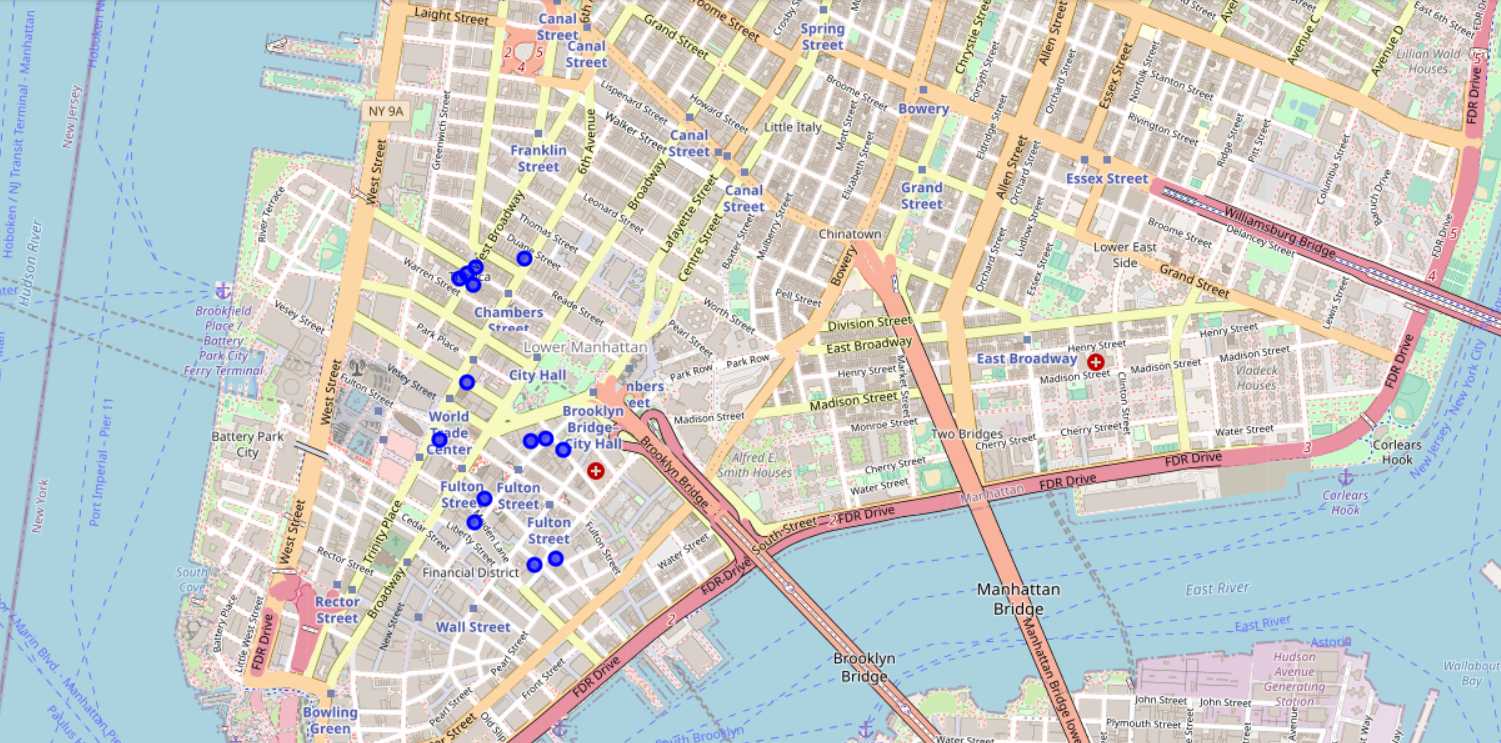

In [ ]:
#How many hotels are there near newyork city center?
hotels_df_filtered.shape[0]

14

In [ ]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n = list(range(1,len(hotels_df_filtered)+1))
hotels_df_filtered['id_n'] = id_n
hotels_df_filtered.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,name,categories,lat,lng,id_n
0,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702,1
1,Four Seasons Hotel New York Downtown,Hotel,40.712612,-74.009380,2
2,"Gild Hall, A Thompson Hotel",Hotel,40.707887,-74.007103,3
3,Artezen Hotel,Hotel,40.709585,-74.008780,4
4,Duane Street Hotel,Hotel,40.715858,-74.007446,5


In [ ]:
# The dataset that will be used in K-Means clustering
X=hotels_df_filtered.loc[:,['id_n','lat','lng']]
X.head(10)

,id_n,lat,lng
0,1,40.711173,-74.006702
1,2,40.712612,-74.009380
2,3,40.707887,-74.007103
3,4,40.709585,-74.008780
4,5,40.715858,-74.007446
5,6,40.715144,-74.009183
6,7,40.715622,-74.009115
7,8,40.710860,-74.006101
8,9,40.711080,-74.007229
9,10,40.715460,-74.009383


**Clustering The Hotels using Kmeans**

In [ ]:
#clustering the hotels based on their locations 
kmeans = KMeans(n_clusters = 4, init ='k-means++') # hotels will be clustered in 3 groups
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
centers = kmeans.cluster_centers_
print(centers) #to show coordinates of the center for each cluster 
X.head(10)

[[ 40.70862082 -74.00783937]
 [ 40.71548148 -74.00895632]
 [ 40.71103766 -74.0066773 ]
 [ 40.71186323 -74.00985666]]


,id_n,lat,lng,cluster_label
0,1,40.711173,-74.006702,2
1,2,40.712612,-74.009380,3
2,3,40.707887,-74.007103,0
3,4,40.709585,-74.008780,0
4,5,40.715858,-74.007446,1
5,6,40.715144,-74.009183,1
6,7,40.715622,-74.009115,1
7,8,40.710860,-74.006101,2
8,9,40.711080,-74.007229,2
9,10,40.715460,-74.009383,1


In [ ]:
#adding the cluster label to each venue in the hotels data frame
X = X[['id_n','cluster_label']]
clustered_hotels = hotels_df_filtered.merge(X, left_on='id_n',right_on='id_n')
clustered_hotels.head()

,name,categories,lat,lng,id_n,cluster_label
0,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702,1,2
1,Four Seasons Hotel New York Downtown,Hotel,40.712612,-74.009380,2,3
2,"Gild Hall, A Thompson Hotel",Hotel,40.707887,-74.007103,3,0
3,Artezen Hotel,Hotel,40.709585,-74.008780,4,0
4,Duane Street Hotel,Hotel,40.715858,-74.007446,5,1


**Folium Map Of Hotels After Clustering**

In [ ]:
#map showing each hotel with different color based on the cluster
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue','black']
for lat, lon, poi, cluster in zip(clustered_hotels['lat'], clustered_hotels['lng'], clustered_hotels['name'], clustered_hotels['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters #show map

In [ ]:
#putting the center of each cluster in a dataframe for later analysis
centers_df = pd.DataFrame(centers, columns =['c_lat', 'c_lon'])
cluster_label = list(range(0,4))
centers_df['cluster_label'] = cluster_label
centers_df

,c_lat,c_lon,cluster_label
0,40.708621,-74.007839,0
1,40.715481,-74.008956,1
2,40.711038,-74.006677,2
3,40.711863,-74.009857,3


In [ ]:
#map of centers
map_centers = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue','black']
for lat, lon, poi, cluster in zip(centers_df['c_lat'], centers_df['c_lon'], centers_df['cluster_label'], centers_df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers)
       
map_centers #display the map showing 3 markers, one for each cluster 

## **Getting the restaurants data from Foursquare and analysing it**

In [ ]:
#creating the url to call on foursquare API

limit_restaurants = 500

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    limit_restaurants)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=EU203ECLXW5SW1V211ZES5RUDZNHLCQ3HKADMVJHBUFZ4YLY&client_secret=IYS0KQOFTEKGJCJZHMKN32GMR1BNBTMS0F0RDDEMDHJNAWGA&v=20200101&ll=40.7127281,-74.0060152&radius=500&limit=500'

In [ ]:
#saving the results
results2 = requests.get(url2).json()

In [ ]:
#getting the needed data and put it in a pandas dataframe
restaurants = results2['response']['groups'][0]['items']
    
restaurants_df = json_normalize(restaurants) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df = restaurants_df.loc[:, filtered_columns]

# filter the category for each row
restaurants_df['venue.categories'] = restaurants_df.apply(get_category_type, axis=1)

# clean columns
restaurants_df.columns = [col.split(".")[-1] for col in restaurants_df.columns]

restaurants_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
1,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
2,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272
3,City Hall Park,Park,40.712359,-74.007493
4,The Class by Taryn Toomey,Gym / Fitness Center,40.712753,-74.008734
...,...,...,...,...
95,P.F. Changs To Go,Restaurant,40.708633,-74.005257
96,Casa Taqueria,Taco Place,40.708694,-74.005791
97,Tribeca's Kitchen,Diner,40.716106,-74.007076
98,Toasties,Deli / Bodega,40.709783,-74.008708


In [ ]:
#number of venues recieved
restaurants_df.shape[0]

100

In [ ]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_cleaned = restaurants_df[restaurants_df['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_cleaned.shape) #number of restaurants
restaurants_df_cleaned.head()

(26, 4)


,name,categories,lat,lng
0,The Hummus & Pita Co,Falafel Restaurant,40.714453,-74.006853
1,Racines,French Restaurant,40.714754,-74.007581
2,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994
3,Temple Court,American Restaurant,40.711491,-74.006832
4,Da Claudio,Italian Restaurant,40.710826,-74.007639


In [ ]:
#creating a map of restaurants
restaurants_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around London

# add the hotels as orange circle markers
for lat, lng, label in zip(restaurants_df_cleaned.lat, restaurants_df_cleaned.lng, restaurants_df_cleaned.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.6
    ).add_to(restaurants_map)

# display map
restaurants_map

In [ ]:
#preparing the data that will be used in KNN classification
Xhat=restaurants_df_cleaned.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat.shape) #number of restaurants
Xhat.head(10) #show dataframe

(26, 2)


,lat,lng
0,40.714453,-74.006853
1,40.714754,-74.007581
2,40.713307,-74.007994
3,40.711491,-74.006832
4,40.710826,-74.007639
5,40.714246,-74.007925
6,40.715537,-74.007725
7,40.710773,-74.009580
8,40.710419,-74.008550
9,40.709418,-74.008056


In [ ]:
#the centers dataframe to be used for training KNN
centers_df 

,c_lat,c_lon,cluster_label
0,40.711863,-74.009857,0
1,40.711038,-74.006677,1
2,40.715481,-74.008956,2
3,40.708621,-74.007839,3


In [ ]:
#selecting classification features and target variable
X_train = centers_df[['c_lat', 'c_lon']].values
Y_train = centers_df['cluster_label']

In [ ]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
#classify the restaurants based on the model created
yhat = neigh.predict(Xhat)
yhat[0:5]

array([2, 2, 0, 1, 1])

In [ ]:
#putting the results in a dataframe
KNN_results = pd.DataFrame(yhat, columns=['class'])
KNN_results

,class
0,2
1,2
2,0
3,1
4,1
5,2
6,2
7,0
8,3
9,3


In [ ]:
#joining the results with the restaurants dataframe
restaurants_classified = pd.concat([restaurants_df_cleaned, KNN_results], axis=1, sort=False)
restaurants_classified

,name,categories,lat,lng,class
0,The Hummus & Pita Co,Falafel Restaurant,40.714453,-74.006853,2
1,Racines,French Restaurant,40.714754,-74.007581,2
2,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994,0
3,Temple Court,American Restaurant,40.711491,-74.006832,1
4,Da Claudio,Italian Restaurant,40.710826,-74.007639,1
5,Gran Morsi,Italian Restaurant,40.714246,-74.007925,2
6,Nish Nūsh,Falafel Restaurant,40.715537,-74.007725,2
7,Nobu Downtown,Japanese Restaurant,40.710773,-74.009580,0
8,Chick-fil-A,Fast Food Restaurant,40.710419,-74.008550,3
9,Nish Nush,Falafel Restaurant,40.709418,-74.008056,3


In [ ]:
#show restaurante in each area in different color
map_rest_class = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue','black']
for lat, lon, poi, cluster in zip(restaurants_classified['lat'], restaurants_classified['lng'], restaurants_classified['name'], restaurants_classified['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class)
       
map_rest_class

## **Finding the suitable spot**

In [ ]:
#count number of restaurants in each area
restaurants_count = restaurants_classified['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count

,class,counts
0,2,14
1,3,6
2,1,4
3,0,2


In [ ]:
#counting number of trending restaurants of each unique category
trending_restaurants = restaurants_classified['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants

,categories,counts
0,Falafel Restaurant,3
1,Italian Restaurant,3
2,American Restaurant,3
3,Indian Restaurant,2
4,French Restaurant,2
5,Sushi Restaurant,2
6,Korean Restaurant,1
7,Restaurant,1
8,Cuban Restaurant,1
9,Japanese Restaurant,1


In [ ]:
#keeping the five most frequent categories
trending_restaurants = trending_restaurants.head()
trending_restaurants

,categories,counts
0,Falafel Restaurant,3
1,Italian Restaurant,3
2,American Restaurant,3
3,Indian Restaurant,2
4,French Restaurant,2


In [ ]:
#make "categories" as index for visiualization
trending_restaurants = trending_restaurants.set_index('categories')
trending_restaurants

,counts
categories,
Falafel Restaurant,3
Italian Restaurant,3
American Restaurant,3
Indian Restaurant,2
French Restaurant,2


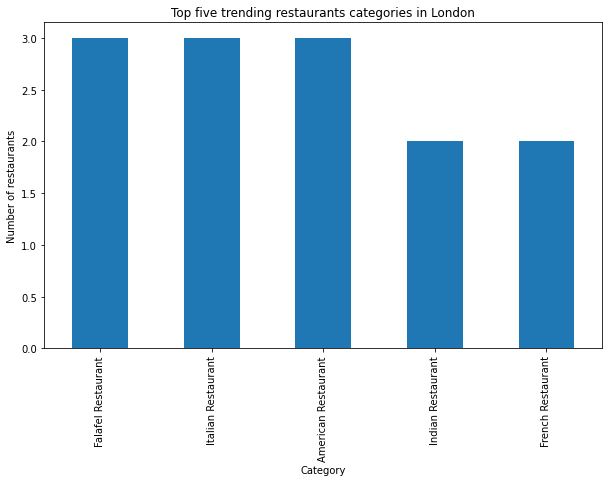

In [ ]:
#plotting the top five restaurant categories
trending_restaurants.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in London') # add title to the plot

plt.show()

In [ ]:
#counting hotels in each area to evaluate potential
hotels_count = clustered_hotels['cluster_label'].value_counts().rename_axis('cluster').reset_index(name='counts')
hotels_count

,cluster,counts
0,2,5
1,3,4
2,1,3
3,0,2
